<b>Author : Aneesh Sathe <b>

# ConvLSTM for Engineering Building B

Hyper-parameters - 
Epoch: 1500
Conv Channels : 64
Kernel : 3
LSTM Layers : 32
LR: 0.001

In-Steps: 5
Out-Steps: 1 (Frequency Prediction for the next timestep)

In [2]:
'''Importing Required Libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob 
import warnings 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch 
from torch import nn
from torchinfo import summary
warnings.filterwarnings('ignore')

## setting manual seed to avoid random initialistion of weights 

In [3]:
torch.manual_seed(42) 

In [4]:
torch.rand(3,4)

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])

## data preprocessing 

In [5]:
'''Loading the Data from File Directory'''
data = sorted(glob.glob('building_B/2022-10-*.csv'))

['building_A/2022-10-02.csv', 'building_A/2022-10-03.csv', 'building_A/2022-10-04.csv', 'building_A/2022-10-05.csv', 'building_A/2022-10-06.csv', 'building_A/2022-10-07.csv', 'building_A/2022-10-08.csv', 'building_A/2022-10-09.csv', 'building_A/2022-10-10.csv', 'building_A/2022-10-11.csv']


In [6]:
def make_data(data):
    month_dfs = []
    '''Read from File, Convert to Dataframe and Concatanate'''
    for _ in data:
        df = pd.read_csv(_, usecols = ['UpdateTime','Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'Freq', 'PF'], index_col = False)
        df = df[['UpdateTime', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'PF', 'Freq' ]]
        df['UpdateTime'] = pd.to_datetime(df['UpdateTime'])
        month_dfs.append(df)
    month_df = pd.concat(month_dfs)
    '''Re-Sample the Data + Reduce Datapoints to Every Minute Interval'''
    resampled_data = month_df.set_index('UpdateTime')
    resampled_data = resampled_data.resample('1T').mean().interpolate(method='linear')
    resampled_data.reset_index(inplace=True)
    X, y = resampled_data.drop(columns = ['UpdateTime']), resampled_data.Freq.values
    return X, y
        

In [7]:
'''Preparing Data into Sequence for LSTM'''
def create_seq(X, y, seq_length):
    sequences_X = []
    sequences_y = []

    for i in range(len(X) - seq_length):
        sequences_X.append(X[i:i+seq_length])
        sequences_y.append(y[i+seq_length])

    seq_X = np.array(sequences_X)
    seq_y = np.array(sequences_y)
    return seq_X, seq_y

In [8]:
def scale_data(X, y):
    mm = MinMaxScaler()
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    y_scaled = mm.fit_transform(y.reshape(-1,1))
    return X_scaled, y_scaled, mm
    

In [9]:
def make_tensor(X_train, X_test, y_train, y_test):
    X_train = torch.tensor(X_train, requires_grad = True)
    X_test = torch.tensor(X_test, requires_grad = True)
    y_train = torch.tensor(y_train, requires_grad = True)
    y_test = torch.tensor(y_test, requires_grad = True)
    return X_train, X_test, y_train, y_test

In [23]:
X, y = make_data(data) # Preparing Data for Building B
X_scaled, y_scaled, mm = scale_data(X, y)

''' Predicting the Next 1 Time Step from Previous 5 Time Steps'''
in_step = 5
X_ss, y_mm = create_seq(X_scaled, y_scaled, in_step) #split into data format for lstm training
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size = 0.3, shuffle = False)
X_train, X_test, y_train, y_test= make_tensor(X_train, X_test, y_train, y_test)


In [24]:
X_train.shape, y_train.shape

(torch.Size([29659, 5, 8]), torch.Size([29659, 1]))

## creating & training the model

In [12]:
class ConvLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv = nn.Conv1d(in_channels = 5, out_channels = 64, kernel_size = 3, padding = 1, dtype=torch.float)
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, num_classes)

        
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = self.relu(conv_out)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, (hn,cn) = self.lstm(conv_out.float(), (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        hn = self.relu(hn)
        out = self.fc1(hn)
        out = self.relu(out)
        out = self.fc2(out)
        return out
        

In [13]:
def training_loop(epochs, conv_lstm, optimiser, loss1, loss2, X_train, y_train, X_test, y_test):
    #X_train, y_train, X_test, y_test = X_train.double(), y_train.double(), X_test.double(), y_test.double()
    mse_train_count, mse_test_count = list(), list()
    mae_train_count, mae_test_count = list(), list()
    min_loss = 100
    for _ in range(epochs):
        conv_lstm.train()
        out = conv_lstm.forward(X_train.float())
        optimiser.zero_grad()
        mse_loss = loss1(out, y_train.float())
        mae_loss = loss2(out, y_train.float())
        mse_loss.backward()
        optimiser.step()
        conv_lstm.eval()
        with torch.inference_mode():
            test_pred = conv_lstm.forward(X_test.float())
            mse_test_loss = loss1(test_pred, y_test.float())
            mae_test_loss = loss2(test_pred, y_test.float())
            if _ % 10 == 0:
                if mse_test_loss.item() < min_loss :
                    min_loss = mse_test_loss.item()
                    torch.save(conv_lstm.state_dict(), 'saved_models_update/convLSTM-B.pth')
                print(f" Epoch : {_} | MSE Train Loss : {mse_loss.item()} | MSE Test Loss : {mse_test_loss.item()} | MAE Train Loss : {mae_loss.item()} | MAE Test Loss : {mae_test_loss.item()}")
                mse_train_count.append(mse_loss.item())
                mse_test_count.append(mse_test_loss.item())   
                mae_train_count.append(mae_loss.item())
                mae_test_count.append(mae_test_loss.item()) 
    '''Plotting Train - Test Loss Graphs'''
    
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,epochs,10), mse_train_count, 'b', label = 'train loss')
    plt.plot(np.arange(0,epochs,10), mse_test_count, 'r', label = 'test loss')
    plt.title('ConvLSTM(A) - MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.savefig('update-figures/conv_lstm_B - MSE Loss')
    
    plt.show()
    plt.figure(figsize = (10,5))
    plt.plot(np.arange(0,epochs,10), mae_train_count, 'b', label = 'train loss')
    plt.plot(np.arange(0,epochs,10), mae_test_count, 'r', label = 'test loss')
    plt.title('ConvLSTM(A) - MAE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.savefig('update-figures/conv_lstm_B - MAE Loss')
    plt.show()

In [14]:
input_size = 8 # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
num_classes = 1 # number of output classes 
conv_lstm = ConvLSTM(num_classes, input_size, hidden_size, num_layers)
loss1 = torch.nn.MSELoss().double()
loss2 = torch.nn.L1Loss().double()
optimiser = torch.optim.Adam(conv_lstm.parameters(), lr = 0.0001)


In [15]:
X_train.shape

torch.Size([29659, 5, 8])

In [16]:
summary(conv_lstm, input_size = (29659, 5, 8))

Layer (type:depth-idx)                   Output Shape              Param #
ConvLSTM                                 [29659, 1]                --
├─Conv1d: 1-1                            [29659, 64, 8]            1,024
├─ReLU: 1-2                              [29659, 64, 8]            --
├─LSTM: 1-3                              [29659, 64, 32]           5,376
├─ReLU: 1-4                              [29659, 32]               --
├─Linear: 1-5                            [29659, 10]               330
├─ReLU: 1-6                              [29659, 10]               --
├─Linear: 1-7                            [29659, 1]                11
Total params: 6,741
Trainable params: 6,741
Non-trainable params: 0
Total mult-adds (G): 10.46
Input size (MB): 4.75
Forward/backward pass size (MB): 610.03
Params size (MB): 0.03
Estimated Total Size (MB): 614.80

 Epoch : 0 | MSE Train Loss : 0.14081475138664246 | MSE Test Loss : 0.1417369842529297 | MAE Train Loss : 0.35740673542022705 | MAE Test Loss : 0.35655710101127625
 Epoch : 10 | MSE Train Loss : 0.13703101873397827 | MSE Test Loss : 0.13793733716011047 | MAE Train Loss : 0.35209420323371887 | MAE Test Loss : 0.3512094020843506
 Epoch : 20 | MSE Train Loss : 0.13330771028995514 | MSE Test Loss : 0.13420341908931732 | MAE Train Loss : 0.34678253531455994 | MAE Test Loss : 0.3458685278892517
 Epoch : 30 | MSE Train Loss : 0.1296326369047165 | MSE Test Loss : 0.1305234581232071 | MAE Train Loss : 0.3414541780948639 | MAE Test Loss : 0.34051916003227234
 Epoch : 40 | MSE Train Loss : 0.12597820162773132 | MSE Test Loss : 0.12684549391269684 | MAE Train Loss : 0.3360695540904999 | MAE Test Loss : 0.3350847661495209
 Epoch : 50 | MSE Train Loss : 0.12224331498146057 | MSE Test Loss : 0.12306272983551025 | MAE Train Loss : 0.33047419786453247 | MAE Test Loss : 0.32940083742141724
 Epoch : 60 |

 Epoch : 500 | MSE Train Loss : 0.01333035808056593 | MSE Test Loss : 0.014702639542520046 | MAE Train Loss : 0.09535188972949982 | MAE Test Loss : 0.1008252203464508
 Epoch : 510 | MSE Train Loss : 0.013298648409545422 | MSE Test Loss : 0.014668602496385574 | MAE Train Loss : 0.09524203836917877 | MAE Test Loss : 0.10072256624698639
 Epoch : 520 | MSE Train Loss : 0.013268155045807362 | MSE Test Loss : 0.014635579660534859 | MAE Train Loss : 0.09513624012470245 | MAE Test Loss : 0.1006225049495697
 Epoch : 530 | MSE Train Loss : 0.01323875691741705 | MSE Test Loss : 0.014603438787162304 | MAE Train Loss : 0.09503436833620071 | MAE Test Loss : 0.10052458196878433
 Epoch : 540 | MSE Train Loss : 0.013210372999310493 | MSE Test Loss : 0.014572083950042725 | MAE Train Loss : 0.09493616223335266 | MAE Test Loss : 0.10042888671159744
 Epoch : 550 | MSE Train Loss : 0.013182904571294785 | MSE Test Loss : 0.014541396871209145 | MAE Train Loss : 0.09484267234802246 | MAE Test Loss : 0.10033570

 Epoch : 990 | MSE Train Loss : 0.012195789255201817 | MSE Test Loss : 0.013044063001871109 | MAE Train Loss : 0.09111800789833069 | MAE Test Loss : 0.09501443058252335
 Epoch : 1000 | MSE Train Loss : 0.012187495827674866 | MSE Test Loss : 0.013031856156885624 | MAE Train Loss : 0.09108550101518631 | MAE Test Loss : 0.09496515989303589
 Epoch : 1010 | MSE Train Loss : 0.012179265730082989 | MSE Test Loss : 0.013019806705415249 | MAE Train Loss : 0.09105317294597626 | MAE Test Loss : 0.09491710364818573
 Epoch : 1020 | MSE Train Loss : 0.012171014212071896 | MSE Test Loss : 0.01300719566643238 | MAE Train Loss : 0.09102220088243484 | MAE Test Loss : 0.09486802667379379
 Epoch : 1030 | MSE Train Loss : 0.012162827886641026 | MSE Test Loss : 0.012994382530450821 | MAE Train Loss : 0.09099095314741135 | MAE Test Loss : 0.0948176383972168
 Epoch : 1040 | MSE Train Loss : 0.012154803611338139 | MSE Test Loss : 0.012982041575014591 | MAE Train Loss : 0.09095589816570282 | MAE Test Loss : 0.0

 Epoch : 1480 | MSE Train Loss : 0.011887396685779095 | MSE Test Loss : 0.012669457122683525 | MAE Train Loss : 0.08995652198791504 | MAE Test Loss : 0.09351210296154022
 Epoch : 1490 | MSE Train Loss : 0.011883364990353584 | MSE Test Loss : 0.012665570713579655 | MAE Train Loss : 0.08994050323963165 | MAE Test Loss : 0.09349730610847473


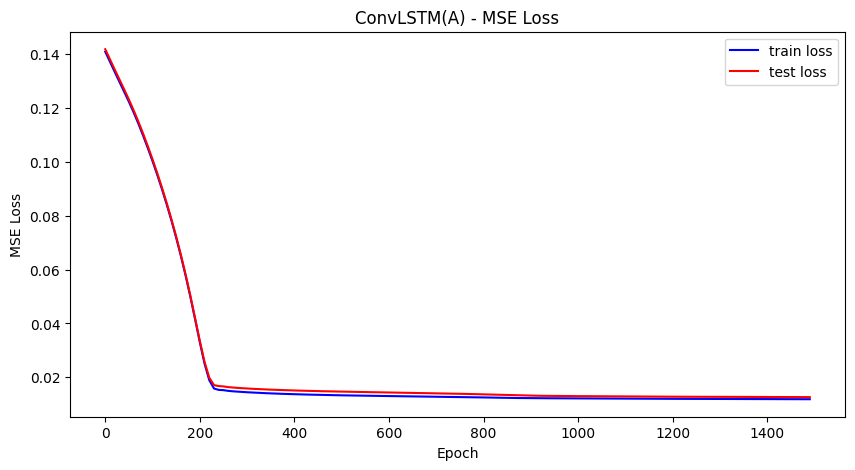

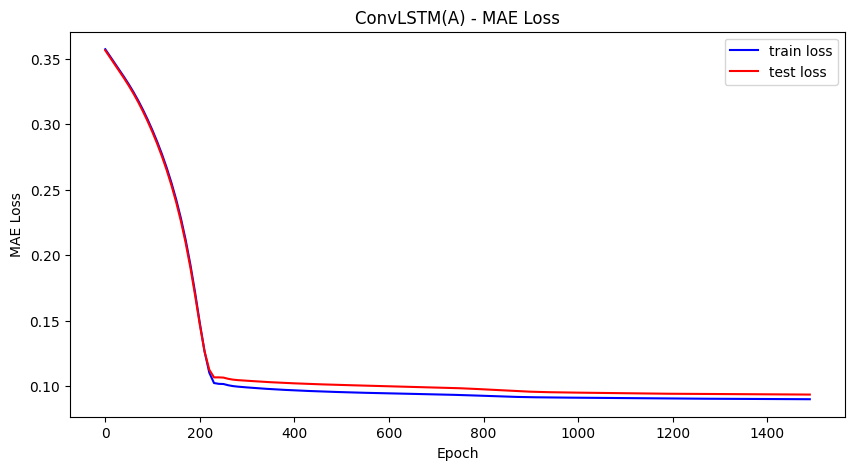

In [20]:
training_loop(1500, conv_lstm, optimiser, loss1, loss2, X_train, y_train, X_test, y_test)

## predictions 

In [21]:
def inverse_scaling(y_pred, y_true, scaler):
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    y_true = scaler.inverse_transform(y_true)
    return y_pred, y_true
    

In [27]:
def make_prediction(X_scaled, y_scaled, lstm_model, scaler, in_step): # pass Original Scaled Dataset as Argument
    X_scaled, y_scaled = create_seq(X_scaled, y_scaled, in_step)
    X , y = torch.tensor(X_scaled), torch.tensor(y_scaled)
    lstm_model.eval()
    y_pred = lstm_model(X.float()) # forward pass
    y_pred = y_pred.detach().numpy()
    y_true = y.numpy()
    y_pred = np.repeat(y_pred, 7, axis = 1 )
    # inverse scaling
    y_pred, y_true = inverse_scaling(y_pred, y_true, scaler)
    return y_pred, y_true
    

In [28]:
y_pred, y_true = make_prediction(X_scaled, y_scaled, conv_lstm , mm, 5)

In [29]:
y_pred[:10]

array([59.939457, 59.94163 , 59.936275, 59.93793 , 59.93738 , 59.93297 ,
       59.936543, 59.93582 , 59.935524, 59.934376], dtype=float32)

In [30]:
y_true[:10].squeeze()

array([59.925     , 59.9       , 59.9       , 59.94      , 59.9       ,
       59.90029412, 59.90058824, 59.90088235, 59.90117647, 59.90147059])

In [31]:
'''State Dict of the Trained Model'''
for param_tensor in conv_lstm.state_dict():
    print(param_tensor, "\t", conv_lstm.state_dict()[param_tensor].size())

conv.weight 	 torch.Size([64, 5, 3])
conv.bias 	 torch.Size([64])
lstm.weight_ih_l0 	 torch.Size([128, 8])
lstm.weight_hh_l0 	 torch.Size([128, 32])
lstm.bias_ih_l0 	 torch.Size([128])
lstm.bias_hh_l0 	 torch.Size([128])
fc1.weight 	 torch.Size([10, 32])
fc1.bias 	 torch.Size([10])
fc2.weight 	 torch.Size([1, 10])
fc2.bias 	 torch.Size([1])


## graphs 

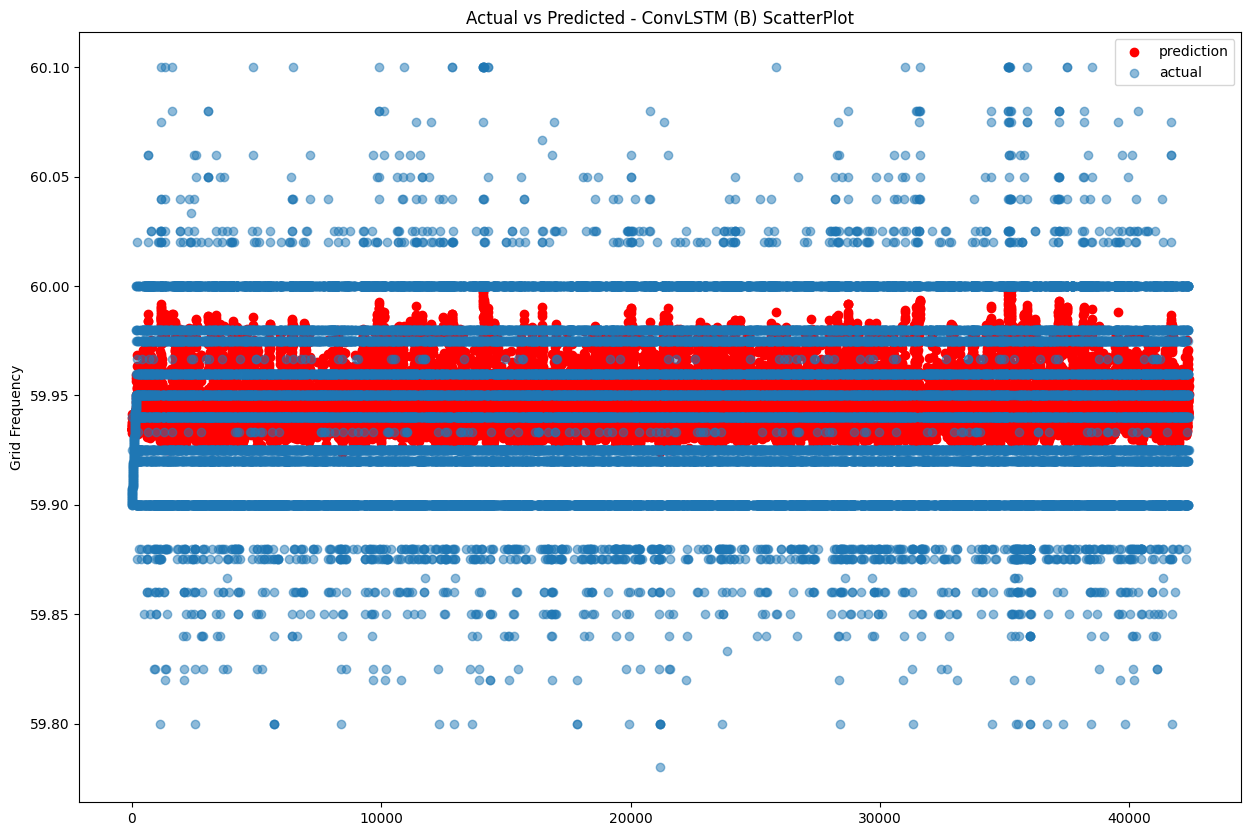

In [32]:
plt.figure(figsize = (15,10))
plt.scatter(np.arange(0,len(y_pred)),y_pred, label = 'prediction', c='r')
plt.scatter(np.arange(0,len(y_pred)),y_true.flatten(), label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (B) ScatterPlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.savefig('update-figures/conv_lstm_B - Scatter Plot.png')
plt.show()

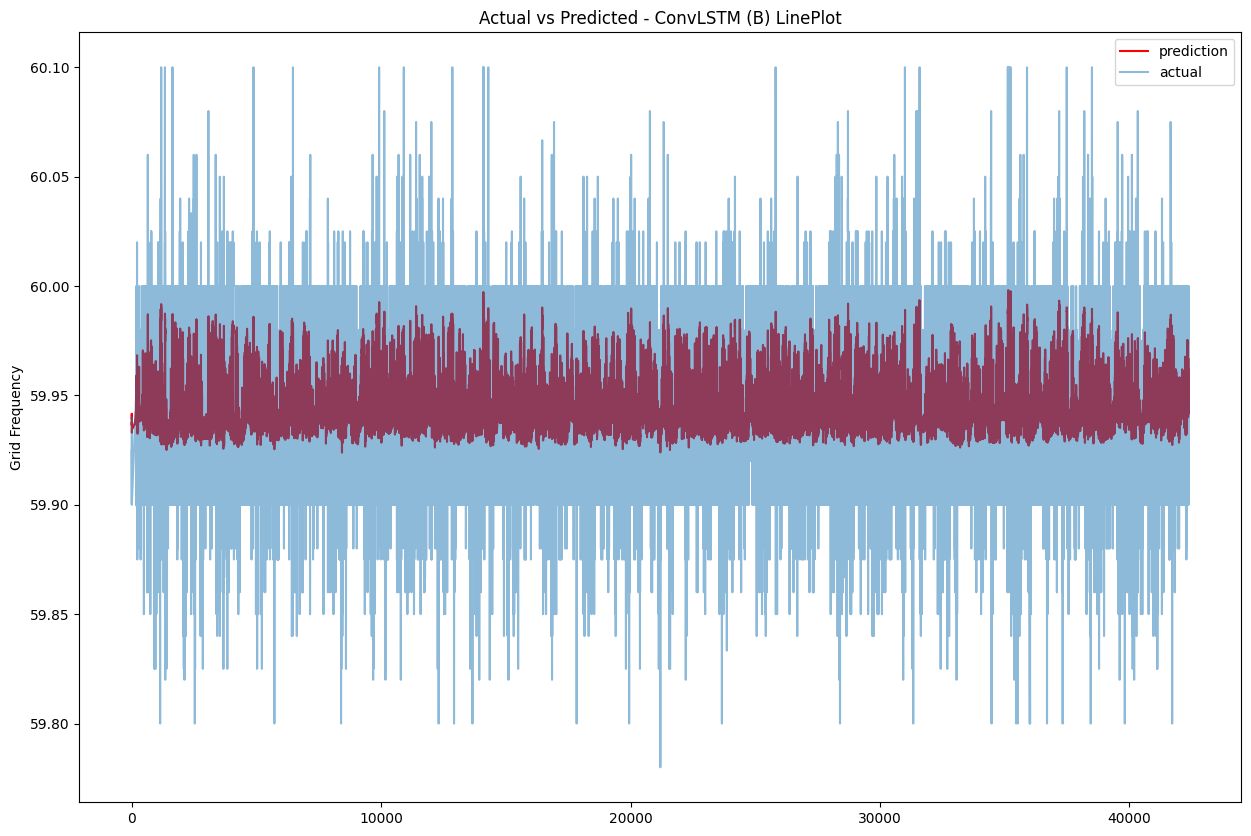

In [33]:
plt.figure(figsize = (15,10))
plt.plot(y_pred, label = 'prediction', c='r')
plt.plot(y_true, label = 'actual', alpha = 0.5)
plt.title('Actual vs Predicted - ConvLSTM (B) LinePlot')
plt.ylabel("Grid Frequency")
plt.legend()
plt.savefig('update-figures/conv_lstm_B - Line Plot.png')
plt.show()